# Serial 2D Multi-grid method

In [1]:
!lsb_release -a
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx

In [279]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import math
import time 

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

## Numerical set up

In [280]:
# Parameters to be defined for different grid size and conductivity
dt = 10      # Time step (s)
dx = 1       # Grid size in x    
dy = 1       # Grid size in y   
Dx = 0.1     # Conductivity in x   
Dy = 0.1     # Conductivity in y   
# Parameters for the computational domain
alpha = 1    # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128     # Grid point in x
ny = 128     # Grid point in x
ub = 1       # Velocity (1m/s)

In [281]:
# the weights matrix                   
w1 = np.zeros([1,2,2,1])             
w2 = np.zeros([1,3,3,1])            
w1[0,:,:,0] = 0.25                  
w2[0][0][1][0] = - Dy*dt/dy**2
w2[0][1][0][0] = - Dx*dt/dx**2 - ub*dt/(dx)                   
w2[0][1][1][0] = 1 + 2*(Dx*dt/dx**2+Dy*dt/dy**2) + 2*ub*dt/(dx) 
w2[0][1][2][0] =  - Dx*dt/dx**2
w2[0][2][1][0] =  - Dy*dt/dy**2 - ub*dt/(dx) 
print('Sum up the weights of filter:', sum(sum(sum(w2))))

Sum up the weights of filter: [1.]


## Weights of layers

In [282]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)) )

## Jacobi matrix 

In [283]:
CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, nx, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer)
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

## Restriction matrix

In [284]:
CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, nx, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
])    
CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

## Prolongation matrix

In [285]:
CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),   
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)), 
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),   
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

## Load data 

In [286]:
# you might need incorporate with SFC code here
T = np.zeros([nx,ny])
for i in range(40):
    for j in range(40):
        T[i+43][j+43] = 1 

In [287]:
input_shape = (1,nx,ny,1)
values = tf.zeros(input_shape)
print('values.shape: ', values.shape)
values = tf.Variable(values)[0,:,:,0].assign(tf.Variable(values)[0,:,:,0]+tf.convert_to_tensor(T.astype('float32')))

values.shape:  (1, 128, 128, 1)


## Initial condition

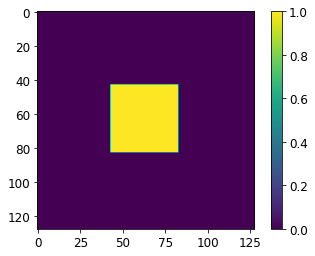

In [288]:
plt.imshow(values[0,:,:,0])
plt.colorbar()
plt.show()

## Multigrid network with skipping layer

In [289]:
start = time.time()
b = values           # only for one time step
multi_itr = 1      # multigrid iteration
j_itr = 1            # jacobi iteration 
for multi_grid in range(multi_itr):    
    w_2 = np.zeros([1,2,2,1])
# --------- Calculate Residual based on initial guess --------  
    r = CNN3D_A_128(values) - b 
# ------------------------------------------------------------  

# --------- Interpolate Residual from finer to coaser mesh --------  
    r_64 = CNN3D_res_128(r) 
    r_32 = CNN3D_res_64(r_64) 
    r_16 = CNN3D_res_32(r_32) 
    r_8 = CNN3D_res_16(r_16) 
    r_4 = CNN3D_res_8(r_8) 
    r_2 = CNN3D_res_4(r_4) 
    # r1 = CNN3D_res_2(r_2)    
# -----------------------------------------------------------------      

# --------- Interpolate Residual from coaser to finer mesh --------  
    # for Jacobi in range(j_itr):
    #     w = w - CNN3D_A_1(w)/w2[0][1][1][0] + r1/w2[0][1][1][0]
    # w = w - CNN3D_A_1(w)/w2[0][1][1][0] + r1/w2[0][1][1][0]
    # w_2 = CNN3D_prol_1(w)                   
    for Jacobi in range(j_itr):
        w_2 = w_2 - CNN3D_A_2(w_2)/w2[0][1][1][0] + r_2/w2[0][1][1][0]
    w_4 = CNN3D_prol_2(w_2) 
    for Jacobi in range(j_itr):
        w_4 = w_4 - CNN3D_A_4(w_4)/w2[0][1][1][0] + r_4/w2[0][1][1][0]
    w_8 = CNN3D_prol_4(w_4) 
    for Jacobi in range(j_itr):
        w_8 = w_8 - CNN3D_A_8(w_8)/w2[0][1][1][0] + r_8/w2[0][1][1][0]
    w_16 = CNN3D_prol_8(w_8) 
    for Jacobi in range(j_itr):
        w_16 = w_16 - CNN3D_A_16(w_16)/w2[0][1][1][0] + r_16/w2[0][1][1][0]
    w_32 = CNN3D_prol_16(w_16) 
    for Jacobi in range(j_itr):
        w_32 = w_32 - CNN3D_A_32(w_32)/w2[0][1][1][0] + r_32/w2[0][1][1][0]
    w_64 = CNN3D_prol_32(w_32)
    for Jacobi in range(j_itr):
        w_64 = w_64 - CNN3D_A_64(w_64)/w2[0][1][1][0] + r_64/w2[0][1][1][0]
    w_128 = CNN3D_prol_64(w_64)
    w_128 = w_128 - CNN3D_A_128(w_128)/w2[0][1][1][0] + r/w2[0][1][1][0]
# ----------------------------------------------------------------- 

# --------- Correct initial guess --------  
    values = values - w_128 
    values = values - CNN3D_A_128(values)/w2[0][1][1][0] + b/w2[0][1][1][0]
# ----------------------------------------  
end = time.time()
print('Computational time(s):',(end-start))
print('Multigrid iterations:', multi_itr)
print('Jacobi iterations:', j_itr)

Computational time(s): 0.03126263618469238
Multigrid iterations: 1
Jacobi iterations: 1


### Residual on 4x4 grid

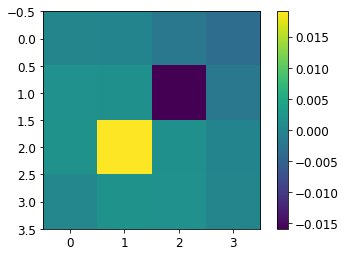

In [290]:
plt.imshow(w_4[0,:,:,0])
plt.colorbar()
plt.show()

### Residual on 8x8 grid

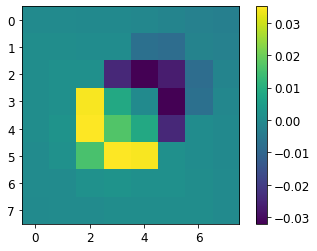

In [291]:
plt.imshow(w_8[0,:,:,0])
plt.colorbar()
plt.show()

### Residual on 16x16 grid

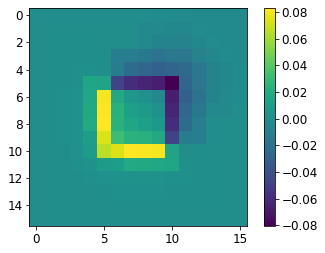

In [292]:
plt.imshow(w_16[0,:,:,0])
plt.colorbar()
plt.show()

### Residual on 32x32 grid

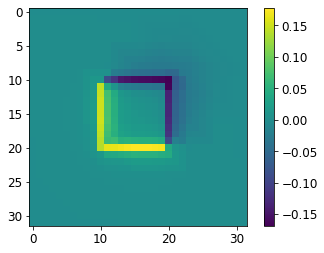

In [293]:
plt.imshow(w_32[0,:,:,0])
plt.colorbar()
plt.show()

### Residual on 64x64 grid

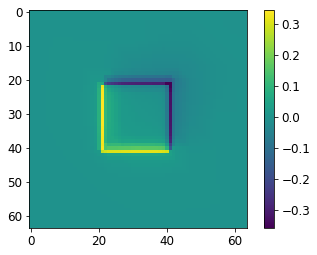

In [294]:
plt.imshow(w_64[0,:,:,0])
plt.colorbar()
plt.show()

### Residual on 128x128 grid

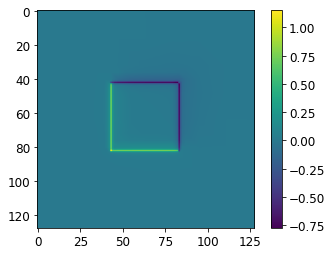

In [295]:
plt.imshow(w_128[0,:,:,0])
plt.colorbar()
plt.show()

### Steady state results

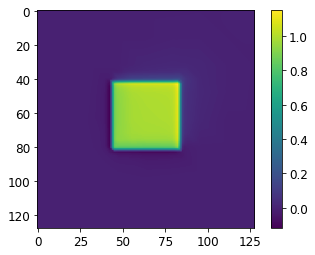

In [296]:
plt.imshow(values[0,:,:,0])
plt.colorbar()
plt.show()

# Try parallelize the 2D case

## pre-installation

In [297]:
## Install the required dependencies
! python -m pip install mpi4py
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## MPI subroutine

In [312]:
%%writefile halo_exchange.py
# imports
import os
import sys
import numpy as np  # cupy can be used as optimisation if CUDA/AMD GPUs are available
from tensorflow import keras
import tensorflow as tf
import math
from mpi4py import MPI

assert tf.__version__ >= "2.0"
np.set_printoptions(threshold=sys.maxsize) # print out the full numpy array

############################## Global variables ################################
comm = None               # MPI communicator
rank = 0                  # Process rank    
num_process = 1           # Number of processors
rows,cols = 1,1           # Cartesian topology for 2D structured mesh
sub_nx, sub_ny, sub_nz = 0,0,0 # Dimensions for sub-domain up to 3D
neighbors = [-2, -2, -2, -2, -2, -2] # Process rank for all neighboring subdomains
current_vector = None     # 1D Block structured sub-domain
current_domain = None     # 2D Block Structured sub-domain
current_cube = None       # 3D Block Structured sub-domain
is_double_precision = False   # variable control the precision of MPI communication buffer vlaues
is_diagonal_exchange = False  # control do we need exchange values on corners

# TODO: the best practice is to use OOP
# class halo_exchange:
#   # initialization
#   def __init__(self) -> None:

#   # member functions
  
############################## Util functions ##################################
# clear the cached subdomain to release memory
def clear_cache():
  global current_domain, current_cube
  if current_domain != None:
    del current_domain
  if current_cube != None:
    del current_cube

def id_2_idx(rank, cols):
    """
    return the indices of processor in processor
    grid space based on the processor ranks

    Parameters
    ----------
    rank : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    return rank/cols, rank % cols

def idx_2_id(rows, cols, id_row, id_col):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    if id_row >= rows or id_row < 0:
        return -1
    if id_col >= cols or id_col < 0:
        return -1
    return id_row * id_col + id_col

def generate_dimension_2D(num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    global rows,cols
    rows,cols = 0,0
    min_gap = num_process
    max_val = int(num_process**0.5 + 1)
    for i in range(1, max_val+1):
        if num_process % i == 0:
            gap = abs(num_process/i - i)
            if gap < min_gap:
                min_gap = gap
                rows = i
                cols = int(num_process / i)

    return rows, cols

def generate_dimension_3D(num_process):
  # TODO: generate dimension for 3D processor grid space
  pass

def domain_decomposition_strip(mesh, num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    sub_domains = np.hsplit(mesh, num_process)
    return sub_domains

def domain_decomposition_grid(mesh, rows, cols):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    nx, ny = mesh.shape
    assert nx % rows == 0, f"{nx} rows is not evenly divisible by {rows}"
    assert ny % cols == 0, f"{ny} cols is not evenly divisible by {cols}"
    sub_nx = nx//rows
    sub_ny = ny//cols
    return (mesh.reshape(nx//sub_nx, sub_nx, -1, sub_ny)
            .swapaxes(1, 2)
            .reshape(-1, sub_nx, sub_ny))
    
def domain_decomposition_cube(mesh, proc_grid_dim):
  """
  return the rank of processor in processor
  grid space based on the indices

  Parameters
  ----------
  rows : int
      the rank of the process
  cols :
      the colun number of the process grid space

  Returns
  -------
  int
      x and y coordinate of the processor

  Raises
  ------
  None
  """
  global sub_nx,sub_ny,sub_nz
  nx, ny, nz = mesh.shape
  
  assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
  assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
  assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"
  
  sub_nx = nx // proc_grid_dim[0]
  sub_ny = ny // proc_grid_dim[1]
  sub_nz = nz // proc_grid_dim[2]

  new_shape = (sub_nx,sub_ny,sub_nz)
  num_cubes = np.array(mesh.shape) // new_shape
  split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
  order = np.array([0,2,4,1,3,5])

  return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape) # return a numpy array


def find_neighbours_id_2D(rank, rows, cols, proc_row_idx, proc_col_idx,num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    # TODO: Consider the conditions in periodic boundaries (if required) 
    # left,right,top,bottom = find_neighbours_id(rank,rows,cols,proc_row_idx,proc_col_idx,num_process)
    # print("[INFO] Neighbors of process {}: left={},right={},up={},down={}".format(rank,left,right,top,bottom))
    left_neighbour = (rank - 1) if proc_col_idx != 0 and rank >=1 else MPI.PROC_NULL
    right_neighbour = (rank + 1) if proc_col_idx != (cols-1) and rank < num_process - 1 else MPI.PROC_NULL
    top_neighbour = (rank - cols) if proc_row_idx != 0 and (rank - cols) >=0 else MPI.PROC_NULL
    bottom_neighbour = (rank + cols) if proc_row_idx != (rows-1) and (rank + cols) <= num_process-1 else MPI.PROC_NULL

    return left_neighbour, right_neighbour, top_neighbour, bottom_neighbour

# padding halos to sub-domain manually
def padding_block_halo_1D(sub_domain,halo_size,halo_val = 0):
  if tf.is_tensor(sub_domain):
     sub_domain = sub_domain.numpy()

  if sub_domain.ndim > 1:
    sub_domain = np.squeeze(sub_domain,axis=0)
    sub_domain = np.squeeze(sub_domain,axis=-1)

  return np.pad(sub_domain,(halo_size,halo_size),'constant',constant_values=(halo_val,))

def padding_block_halo_2D(sub_domain,halo_size,halo_val = 0):
  if tf.is_tensor(sub_domain):
     sub_domain = sub_domain.numpy()

  if sub_domain.ndim > 2:
    sub_domain = np.squeeze(sub_domain)

  # note padding halo values with 0 by default
  return np.pad(sub_domain,(halo_size,halo_size),'constant',constant_values=(halo_val,))

# incase we need diff size of halos on each boudary
def padding_block_halo_2D_custom(sub_domain,halo_dim,halo_vals):
  pass 

def padding_block_halo_3D(sub_cube,halo_size,halo_val = 0):
  if tf.is_tensor(sub_cube):
    sub_cube = sub_cube.numpy()

  if sub_cube.ndim > 3:
    sub_cube = remove_one_dims(sub_cube)
  
  nx,ny,nz = sub_cube.shape

  # note padding halo values with 0 by default
  ans = np.pad(sub_cube,(halo_size,halo_size),'constant',constant_values=(halo_val,))
  return tf.convert_to_tensor(ans.reshape(1,nx+2,ny+2,nz+2,1))

# incase we need diff size of halos on each boudary
def padding_block_halo_3D_custom(sub_cube,halo_dim,halo_vals):
  pass 


# remove trivial 1 dimensions of the tensor.numpy()
def remove_one_dims(input):
  while input.ndim > 3:
      if input.shape[0] == 1:
          input = np.squeeze(input,axis = 0)
      if input.shape[-1] == 1:
          input = np.squeeze(input,axis = -1)
  return  input

############################## MPI Initialization ##############################
def mpi_initialization(proc_grid_dim,is_periodic,is_reordered):
  global rank,num_process,comm

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

  # create Cartesian Topology
  comm = MPI.COMM_WORLD.Create_cart(
    proc_grid_dim,
    periods=is_periodic, # set True if periodic boundary
    reorder=is_reordered)
  
  # get the rank of current process
  rank = comm.rank

def domain_decomposition_1D(values, nx, is_periodic=False,is_reordered=True):
  global num_process,comm,rank, sub_nx, neighbors, current_vector
  LEFT = 0
  RIGHT = 1

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  proc_grid_dim = (num_process,)
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

  neighbors[LEFT], neighbors[RIGHT] = comm.Shift(0, 1)

  print("NEIGHBORS OF {} ".format(rank),neighbors)

  sub_domains = domain_decomposition_strip(values.reshape(nx,), num_process)  # (1,x)
  sub_nx = sub_domains[rank].shape[0]
  current_vector = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

  return sub_nx, current_vector

# grid decomposition for 2D block structured meshes
def domain_decomposition_2D(values, nx, ny, is_periodic=(False,False),is_reordered=True):
  global comm,rank, sub_nx, sub_ny, neighbors,current_domain

  TOP = 0
  BOTTOM = 1
  LEFT = 2
  RIGHT = 3

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  proc_grid_dim = generate_dimension_2D(num_process)
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

  if rows == 1 or cols == 1:
    sub_domains = domain_decomposition_strip(values.reshape(nx,ny), num_process)  # 2 process
    sub_nx, sub_ny = sub_domains[0].shape
  else:
    # if the process arrays is 2D then use grid decomposition to split domain
    sub_domains = domain_decomposition_grid(values.reshape(nx,ny), rows, cols)
    sub_nx, sub_ny = sub_domains[0].shape

  # create customized MPI datatype
  grid_size = [sub_nx,sub_ny]
  subdomain_size = [sub_nx+2, sub_ny + 2]
  start_indices = [1,1]

  # customised data type for 2D problem
  # comm_datatype = MPI.DOUBLE.Create_subarray(subdomain_size, grid_size, start_indices).Commit()

  # find the processor id of all neighboring processors
  neighbors[TOP], neighbors[BOTTOM] = comm.Shift(0, 1)
  neighbors[LEFT],  neighbors[RIGHT]  = comm.Shift(1, 1)

  current_domain = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

  return sub_nx, sub_ny, current_domain

# grid decomposition for 3D block structured meshes
def domain_decomposition_3D(values, nx, ny, nz, is_periodic=(False,False,False),is_reordered=True):
  global rank, num_process, neighbors, current_cube

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  # TODO: create Cartesian topology for processes in 3D space
  proc_grid_dim = (2,2,2) # divide to 2x2x2, 8 subcubes
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)
  
  # edge case, if 1 process we do nothing
  if num_process == 1:
    return nx,ny,nz,values

  if tf.is_tensor(values):
    sub_cubes = domain_decomposition_cube(tf.reshape(values,[nx,ny,nz]).numpy(),proc_grid_dim)
    # we can do this in complete tensorflow routines
    # current_cube = tf.convert_to_tensor(sub_cubes[rank], dtype=tf.float32)
    # paddings = tf.constant([[1, 1], [1, 1], [1, 1]])
    # current_cube = tf.pad(current_cube, paddings)
  else:
    sub_cubes = domain_decomposition_cube(values.reshape(nx,ny,nz),proc_grid_dim) # if it is numpy reshape directly

  # create customized MPI datatype
  cube_size = [sub_nx,sub_ny,sub_nz]
  subcube_size = [sub_nx+2, sub_ny + 2, sub_nz + 2]
  start_indices = [1,1,1]

  # use datatypes with 64 bits
  # comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices).Commit()

  # padding the halo grids
  current_cube = np.pad(sub_cubes[rank],(1,1),'constant',constant_values=(0,))

  # print("[CURRENT_CUBE_SHAPE of {}]".format(rank), current_cube.shape)


  # find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
  neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
  neighbors[FRONT],  neighbors[BEHIND]  = comm.Shift(1, 1)
  neighbors[BOTTOM],  neighbors[TOP]  = comm.Shift(0, 1)

  # print("[NEIGHBORS of {}] ".format(rank),neighbors)

  # return tf.convert_to_tensor(current_cube,np.float64)
  return sub_nx, sub_ny, sub_nz, current_cube

def structured_halo_update_1D(input_vector):
  global comm,neighbors,current_vector,sub_nx

  if tf.is_tensor(input_vector):
     current_vector = input_vector.numpy()
  else:
    current_vector = input_vector

  if current_vector.ndim > 1:
    current_vector = np.squeeze(current_vector,axis=0)
    current_vector = np.squeeze(current_vector,axis=-1)

  #print("reduced shape: ",current_vector.shape)  

  LEFT = 0
  RIGHT = 1

  sub_nx = current_vector.shape[0]

  send_left = np.copy(np.ascontiguousarray(current_vector[1]))
  recv_right = np.empty_like(send_left)
  send_right = np.copy(np.ascontiguousarray(current_vector[-2]))
  recv_left = np.empty_like(send_right)

  comm.Send(buf=[send_left,1,MPI.DOUBLE],dest=neighbors[LEFT],tag=11) # send to left
  comm.Send(buf=[send_right,1,MPI.DOUBLE],dest=neighbors[RIGHT],tag=22) # send to left
  comm.Recv(buf=[recv_right,1,MPI.DOUBLE],source=neighbors[RIGHT],tag=11)
  comm.Recv(buf=[recv_left,1,MPI.DOUBLE],source=neighbors[LEFT],tag=22)

  # Non-blocking send-recv, which gives the same result
  # requests = []
  # requests.append(comm.Isend([send_left,1,MPI.DOUBLE],dest=neighbors[LEFT]))
  # requests.append(comm.Isend([send_right,1,MPI.DOUBLE],dest=neighbors[RIGHT]))
  # requests.append(comm.Irecv([recv_right,1,MPI.DOUBLE],source=neighbors[RIGHT]))
  # requests.append(comm.Irecv([recv_left,1,MPI.DOUBLE],source=neighbors[LEFT]))
  # MPI.Request.Waitall(requests)

  if neighbors[RIGHT] != -2:
    current_vector[-1] = recv_right
  if neighbors[LEFT] != -2:
    current_vector[0] = recv_left

  return tf.convert_to_tensor(current_vector.reshape(1,sub_nx,1))

# parallel halo update for 2D block structured mesh
def structured_halo_update_2D(input_domain):
  global comm,neighbors,current_domain,sub_nx,sub_ny

  current_domain = input_domain

  if tf.is_tensor(input_domain):
     current_domain = input_domain.numpy()

  if current_domain.ndim > 2:
    current_domain = remove_one_dims(current_domain)

  sub_nx, sub_ny = current_domain.shape

  # neighbor indices
  TOP = 0
  BOTTOM = 1
  LEFT = 2
  RIGHT = 3
  
  # left and right
  # try non-blocking send and blocking receive
  send_left = np.copy(np.ascontiguousarray(current_domain[1:-1,1]))
  recv_right = np.zeros_like(send_left)
  send_right = np.copy(np.ascontiguousarray(current_domain[1:-1,-2]))
  recv_left = np.zeros_like(send_right)

  # Non-blocking send
  comm.Send(buf=[send_left,MPI.DOUBLE],dest=neighbors[LEFT],tag=11) # send to left
  comm.Send(buf=[send_right,MPI.DOUBLE],dest=neighbors[RIGHT],tag=22) # send to left
  comm.Recv(buf=[recv_right,MPI.DOUBLE],source=neighbors[RIGHT],tag=11)
  comm.Recv(buf=[recv_left,MPI.DOUBLE],source=neighbors[LEFT],tag=22)
  if neighbors[RIGHT] != -2:
    current_domain[1:-1,-1] = recv_right
  if neighbors[LEFT] != -2:
    current_domain[1:-1,0] = recv_left

  send_top = np.copy(np.ascontiguousarray(current_domain[1,:]))
  recv_bottom = np.zeros_like(send_top)
  send_bottom = np.copy(np.ascontiguousarray(current_domain[-2,:]))
  recv_top = np.zeros_like(send_bottom)

  comm.Send(buf=[send_top,MPI.DOUBLE],dest=neighbors[TOP],tag=33) # send to left
  comm.Send(buf=[send_bottom,MPI.DOUBLE],dest=neighbors[BOTTOM],tag=44) # send to left
  comm.Recv(buf=[recv_bottom,MPI.DOUBLE],source=neighbors[BOTTOM],tag=33)
  comm.Recv(buf=[recv_top,MPI.DOUBLE],source=neighbors[TOP],tag=44)
  if neighbors[TOP] != -2:
    current_domain[0,:] = recv_top
  if neighbors[BOTTOM] != -2:
    current_domain[-1,:] = recv_bottom

  # return current_domain
  return tf.convert_to_tensor(current_domain.reshape(1,sub_nx, sub_ny,1))

# parallel halo update for 3D block structured mesh
# def structured_halo_update_3D(input_cube):
#   global current_cube, neighbors,sub_nx, sub_ny,sub_nz

#   sub_nx, sub_ny, sub_nz = input_cube.shape
  
#   # input cube is a 3D numpy array
#   current_cube = tf.reshape(input_cube,[sub_nx, sub_ny, sub_nz]).numpy()

#   # neighbor indices
#   LEFT = 0
#   RIGHT = 1
#   FRONT = 2
#   BEHIND = 3
#   TOP = 4
#   BOTTOM = 5

#   # FRONT AND BEHIND
#   front_buffer = np.copy(np.ascontiguousarray(current_cube[1:-1, 1, 1:-1]))
#   behind_buffer = np.copy(np.ascontiguousarray(current_cube[1:-1, -2, 1:-1]))
#   comm.Sendrecv_replace(front_buffer,neighbors[FRONT],0,neighbors[FRONT],1)
#   comm.Sendrecv_replace(behind_buffer,neighbors[BEHIND],1,neighbors[BEHIND],0)

#   if neighbors[FRONT] != -2:
#     current_cube[1:-1,0,1:-1] = front_buffer
#   if neighbors[BEHIND] != -2:
#     current_cube[1:-1,-1,1:-1] = behind_buffer

#   del front_buffer,behind_buffer # release memory

#   # LEFT AND RIGHT
#   left_buffer = np.copy(np.ascontiguousarray(current_cube[:, :, 1]))
#   right_buffer = np.copy(np.ascontiguousarray(current_cube[:, :, -2]))
#   comm.Sendrecv_replace(left_buffer,neighbors[LEFT],2,neighbors[LEFT],3)
#   comm.Sendrecv_replace(right_buffer,neighbors[RIGHT],3,neighbors[RIGHT],2)

#   # Update the left and right
#   if neighbors[LEFT] != -2:
#     current_cube[:,:,0] = left_buffer
#   if neighbors[RIGHT] != -2:
#     current_cube[:,:,-1] = right_buffer

#   del left_buffer,right_buffer # release memory

#   #TOP AND BOTTOM
#   top_buffer = np.copy(np.ascontiguousarray(current_cube[-2,:,:]))
#   bottom_buffer = np.copy(np.ascontiguousarray(current_cube[1,:,:]))
#   comm.Sendrecv_replace(top_buffer,neighbors[TOP],4,neighbors[TOP],5)
#   comm.Sendrecv_replace(bottom_buffer,neighbors[BOTTOM],5,neighbors[BOTTOM],4)

#   if neighbors[TOP] != -2:
#     current_cube[-1,:,:] = top_buffer
#   if neighbors[BOTTOM] != -2:
#     current_cube[0,:,:] = bottom_buffer

#   del top_buffer,bottom_buffer # release memory
    
#   return tf.convert_to_tensor(current_cube.reshape(1,sub_nx,sub_ny,sub_nz,1))

# non-blocking send and recv
def structured_halo_update_3D(input_cube):
  global current_cube, neighbors,sub_nx, sub_ny,sub_nz

  current_cube = input_cube

  if tf.is_tensor(input_cube):
     current_cube = current_cube.numpy()

  if input_cube.ndim > 3:
    current_cube = remove_one_dims(current_cube)

  sub_nx,sub_ny,sub_nz = current_cube.shape

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  requests = [] # [ None ] * (2*nprocs) for other languages

  # FRONT AND BEHIND
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1,1,1:-1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1,-2,1:-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[FRONT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[FRONT]))
  MPI.Request.Waitall(requests)

  # update front and behind
  if neighbors[FRONT] != -2:
    current_cube[1:-1,0,1:-1] = recvbuffer_2
  if neighbors[BEHIND] != -2:
    current_cube[1:-1,-1,1:-1] = recvbuffer_1

  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:,:,1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:,:,-2]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)

  if neighbors[LEFT] != -2:
    current_cube[:,:,0] = recvbuffer_2
  if neighbors[RIGHT] != -2:
    current_cube[:,:,-1] = recvbuffer_1

  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-2,:,:]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1,:,:]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
  MPI.Request.Waitall(requests)

  if neighbors[TOP] != -2:
    current_cube[-1,:,:] = recvbuffer_2
  if neighbors[BOTTOM] != -2:
    current_cube[0,:,:] = recvbuffer_1

  return tf.convert_to_tensor(current_cube.reshape(1,sub_nx,sub_ny,sub_nz,1))

def halo_update_1_cube(input_cube):
  global current_cube, neighbors,sub_nx, sub_ny,sub_nz

  sub_nx, sub_ny, sub_nz = input_cube.shape
  
  # input cube is a 3D numpy array
  current_cube = tf.reshape(input_cube,[sub_nx, sub_ny, sub_nz]).numpy()

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  requests = []

  # FRONT AND BEHIND
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1,0,1:-1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1,-1,1:-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[FRONT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[FRONT]))
  MPI.Request.Waitall(requests)

  if neighbors[FRONT] != -2:
    current_cube[1:-1,0,1:-1] = recvbuffer_2
  if neighbors[BEHIND] != -2:
    current_cube[1:-1,-1,1:-1] = recvbuffer_1

  # LEFT AND RIGHT
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:,:,0]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:,:,-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)

  # Update the left and right
  if neighbors[LEFT] != -2:
    current_cube[:,:,0] = recvbuffer_2
  if neighbors[RIGHT] != -2:
    current_cube[:,:,-1] = recvbuffer_1

  #TOP AND BOTTOM
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-1,:,:]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[0,:,:]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
  MPI.Request.Waitall(requests)

  if neighbors[TOP] != -2:
    current_cube[-1,:,:] = recvbuffer_2
  if neighbors[BOTTOM] != -2:
    current_cube[0,:,:] = recvbuffer_1

  return tf.convert_to_tensor(current_cube.reshape(1,sub_nx,sub_ny,sub_nz,1))

Overwriting halo_exchange.py


## Parallelisation

In [319]:
%%writefile parallel_multigrid_2D.py

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import math
import time

# import MPI subdomain
import halo_exchange

# Parameters to be defined for different grid size and conductivity
dt = 10      # Time step (s)
dx = 1       # Grid size in x    
dy = 1       # Grid size in y   
Dx = 0.1     # Conductivity in x   
Dy = 0.1     # Conductivity in y   
# Parameters for the computational domain
alpha = 1    # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128     # Grid point in x
ny = 128     # Grid point in x
ub = 1       # Velocity (1m/s)

# the weights matrix                   
w1 = np.zeros([1,2,2,1])             
w2 = np.zeros([1,3,3,1])            
w1[0,:,:,0] = 0.25                  
w2[0][0][1][0] = - Dy*dt/dy**2
w2[0][1][0][0] = - Dx*dt/dx**2 - ub*dt/(dx)                   
w2[0][1][1][0] = 1 + 2*(Dx*dt/dx**2+Dy*dt/dy**2) + 2*ub*dt/(dx) 
w2[0][1][2][0] =  - Dx*dt/dx**2
w2[0][2][1][0] =  - Dy*dt/dy**2 - ub*dt/(dx) 

kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, nx, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer)
])

CNN3D_A_66 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(66, 66, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_34 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(34, 34, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_18 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(18, 18, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_10 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(10, 10, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_6 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(6, 6, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, nx, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
])    
CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),   
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)), 
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),   
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
])

# you might need incorporate with SFC code here
T = np.zeros([nx,ny])
for i in range(38):
    for j in range(38):
        T[i+44][j+44] = 1 

T = T[2:-2,2:-2]

# domain decomposition
sub_nx, sub_ny, current_domain = halo_exchange.domain_decomposition_2D(T,nx-4,ny-4)

rank = halo_exchange.rank

current_domain = halo_exchange.structured_halo_update_2D(current_domain) # update onetime before the multigrid
current_domain = current_domain.numpy().reshape(64,64)

input_shape = (1,sub_nx+2,sub_ny+2,1)
values = tf.zeros(input_shape)
values = tf.Variable(values)[0,:,:,0].assign(tf.Variable(values)[0,:,:,0]+tf.convert_to_tensor(current_domain.astype('float32')))

start = time.time()
b = values           # only for one time step
multi_itr = 1     # multigrid iteration
j_itr = 1            # jacobi iteration 
for multi_grid in range(multi_itr):    
    w = np.zeros([1,1,1,1])
# --------- Calculate Residual based on initial guess --------  
    # r = CNN3D_A_128(values) - b 
    r = CNN3D_A_64(values) - b 
# ------------------------------------------------------------  
    r = halo_exchange.structured_halo_update_2D(r) # update for the residual

    np.save("r_{}".format(rank), r)
# --------- Interpolate Residual from finer to coaser mesh --------  
    # r_64 = CNN3D_res_128(r) 
    r_32 = CNN3D_res_64(r) 
    r_16 = CNN3D_res_32(r_32) 
    r_8 = CNN3D_res_16(r_16) 
    r_4 = CNN3D_res_8(r_8) 
    r_2 = CNN3D_res_4(r_4) 
    r1 = CNN3D_res_2(r_2)    
# -----------------------------------------------------------------      

# --------- Interpolate Residual from coaser to finer mesh --------  
    for Jacobi in range(j_itr):
        w = w - CNN3D_A_1(w)/w2[0][1][1][0] + r1/w2[0][1][1][0]
    w = w - CNN3D_A_1(w)/w2[0][1][0] + r1/w2[0][1][0]
    
    w_2 = CNN3D_prol_1(w)                   
    w_t1 = halo_exchange.padding_block_halo_2D(w_2,1)
    w_t1 = halo_exchange.structured_halo_update_2D(w_t1)     
    for Jacobi in range(j_itr):
        temp = CNN3D_A_4(w_t1)
        w_2 = w_2 - temp/w2[0][1][1][0] + r_2/w2[0][1][1][0]

    w_4 = CNN3D_prol_2(w_2) 
    w_t2 = halo_exchange.padding_block_halo_2D(w_4,1)
    w_t2 = halo_exchange.structured_halo_update_2D(w_t2) 
    for Jacobi in range(j_itr):
        temp = CNN3D_A_6(w_t2)
        w_4 = w_4 - temp/w2[0][1][1][0] + r_4/w2[0][1][1][0]

    w_8 = CNN3D_prol_4(w_4)
    w_t3 = halo_exchange.padding_block_halo_2D(w_8,1)
    w_t3 = halo_exchange.structured_halo_update_2D(w_t3)  
    for Jacobi in range(j_itr):
        temp = CNN3D_A_10(w_t3)
        w_8 = w_8 - temp/w2[0][1][1][0] + r_8/w2[0][1][1][0]

    w_16 = CNN3D_prol_8(w_8)
    w_t4 = halo_exchange.padding_block_halo_2D(w_16,1)
    w_t4 = halo_exchange.structured_halo_update_2D(w_t4)  
    for Jacobi in range(j_itr):
        temp = CNN3D_A_18(w_t4)
        w_16 = w_16 - temp/w2[0][1][1][0] + r_16/w2[0][1][1][0]

    w_32 = CNN3D_prol_16(w_16) 
    w_t5 = halo_exchange.padding_block_halo_2D(w_32,1)
    w_t5 = halo_exchange.structured_halo_update_2D(w_t5) 
    for Jacobi in range(j_itr):
        temp = CNN3D_A_34(w_t5)
        w_32 = w_32 - temp/w2[0][1][1][0] + r_32/w2[0][1][1][0]

    w_64 = CNN3D_prol_32(w_32)
    w_t6 = halo_exchange.padding_block_halo_2D(w_64,1)
    w_t6 = halo_exchange.structured_halo_update_2D(w_t6)
    for Jacobi in range(j_itr):
        temp = CNN3D_A_66(w_t6)
        w_64 = w_64 - temp/w2[0][1][1][0] + r/w2[0][1][1][0]

    # w_128 = CNN3D_prol_64(w_64)
    # w_128 = w_128 - CNN3D_A_128(w_128)/w2[0][1][1][0] + r/w2[0][1][1][0]
# ----------------------------------------------------------------- 

# --------- Correct initial guess --------  
    # values = values - w_128 
    # values = values - CNN3D_A_128(values)/w2[0][1][1][0] + b/w2[0][1][1][0]

    values = values - w_64
    values = values - CNN3D_A_64(values)/w2[0][1][1][0] + b/w2[0][1][1][0]
    values = halo_exchange.structured_halo_update_2D(values)
# ----------------------------------------  
np.save("/content/parallel_output/parallel_res_{}".format(rank),values)
np.save("/content/parallel_residuals/w_{}".format(rank),w)
np.save("/content/parallel_residuals/w2_{}".format(rank),w_2)
np.save("/content/parallel_residuals/w4_{}".format(rank),w_4)
np.save("/content/parallel_residuals/w8_{}".format(rank),w_8)
np.save("/content/parallel_residuals/w16_{}".format(rank),w_16)
np.save("/content/parallel_residuals/w32_{}".format(rank),w_32)
np.save("/content/parallel_residuals/w64_{}".format(rank),w_64)
end = time.time()
print('Computational time(s):',(end-start))
print('Multigrid iterations:', multi_itr)
print('Jacobi iterations:', j_itr)

Overwriting parallel_multigrid_2D.py


In [320]:
! mkdir parallel_output
! mkdir parallel_residuals

mkdir: cannot create directory ‘parallel_output’: File exists
mkdir: cannot create directory ‘parallel_residuals’: File exists


## Run parallelisation

In [321]:
! mpiexec --allow-run-as-root -n 4 python parallel_multigrid_2D.py

2022-08-29 16:30:46.219045: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-29 16:30:46.221488: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-29 16:30:46.222781: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-29 16:30:46.228891: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Computational time(s): 0.04479336738586426
Multigrid iterations: 1
Jacobi iterations: 1
Computational time(s): 0.044448137283325195
Multigrid iterations: 1
Jacobi iterations: 1
Computational time(s): 0.044448137283325195
Multigrid iterations: 1
Jacobi iterations: 1
Computational time(s): 0.0450897216796875
Multigrid iterations: 1
Jacobi iterations: 1

## Check the initial condition

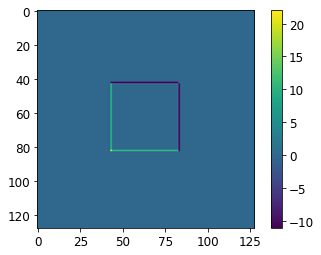

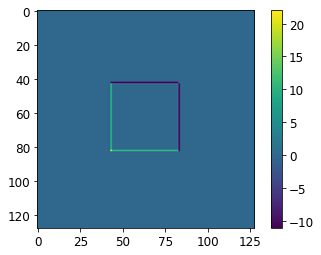

In [322]:
plt.imshow(r[0,:,:,0])
plt.colorbar()
plt.show()

r_1 = np.load("/content/r_0.npy")[0,:,:,0]
r_2 = np.load("/content/r_1.npy")[0,:,:,0]
r_3 = np.load("/content/r_2.npy")[0,:,:,0]
r_4 = np.load("/content/r_3.npy")[0,:,:,0]
parallel_r_1 = np.concatenate([r_1,r_2],axis=1) # this time we only need to combine horizontally
parallel_r_2 = np.concatenate([r_3,r_4],axis=1) # this time we only need to combine horizontally
parallel_r = np.concatenate([parallel_r_1,parallel_r_2],axis=0)

plt.imshow(parallel_r)
plt.colorbar()
plt.show()

# should be the same
assert np.allclose(r[0,:,:,0],parallel_r)
# a = r[0,:,:,0]
# a = parallel_r
# print(np.where(a == 1))

## Result analysis

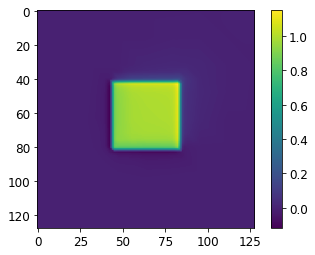

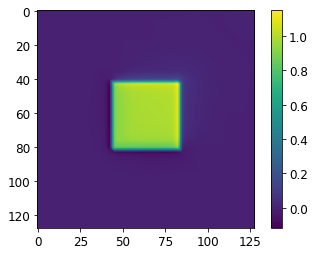

ABE: 0.053407542
AVG NORM ABE:  6.402842700481415e-08


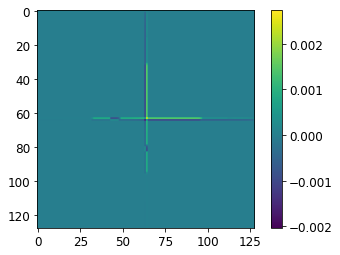

In [323]:
import numpy.linalg as LA

plt.imshow(values[0,:,:,0])
plt.colorbar()
plt.show()

res_1 = np.load('/content/parallel_output/parallel_res_0.npy')[0,:,:,0]
res_2 = np.load('/content/parallel_output/parallel_res_1.npy')[0,:,:,0]
res_3 = np.load('/content/parallel_output/parallel_res_2.npy')[0,:,:,0]
res_4 = np.load('/content/parallel_output/parallel_res_3.npy')[0,:,:,0]

parallel_solution_1 = np.concatenate([res_1,res_2],axis=1) # this time we only need to combine horizontally
parallel_solution_2 = np.concatenate([res_3,res_4],axis=1) # this time we only need to combine horizontally
parallel_solution = np.concatenate([parallel_solution_1,parallel_solution_2],axis=0)
plt.imshow(parallel_solution)
plt.colorbar()
plt.show()
print("ABE:",np.sum(np.abs((values[0,:,:,0])) - np.abs(parallel_solution)))
print("AVG NORM ABE: ",np.abs(LA.norm(values[0,:,:,0]) - LA.norm(parallel_solution)) / (128*128))
parallel_solution.shape

# chek where is the accuracy error
a = np.abs((values[0,:,:,0])) - np.abs(parallel_solution)
plt.imshow(a)
plt.colorbar()
plt.show()
# how was this error caused?

## residual 2x2

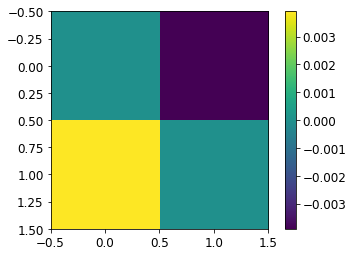

tf.Tensor(
[[ 0.         -0.00390625]
 [ 0.00390625  0.        ]], shape=(2, 2), dtype=float32)
[[ 0.         -0.00390625]
 [ 0.00390625  0.        ]]
0.0


(1, 2, 2, 1)

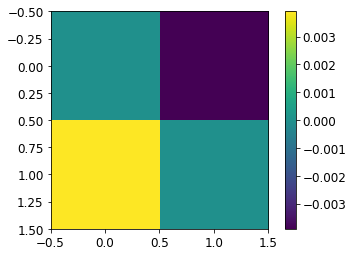

In [324]:
plt.imshow(w_2[0,:,:,0])
plt.colorbar()
plt.show()

pw_1 = np.load('/content/parallel_residuals/w_0.npy')
pw_2 = np.load('/content/parallel_residuals/w_1.npy')
pw_3 = np.load('/content/parallel_residuals/w_2.npy')
pw_4 = np.load('/content/parallel_residuals/w_3.npy')

parallel_w_1 = np.concatenate([pw_1,pw_2],axis=2) # this time we only need to combine horizontally
parallel_w_2 = np.concatenate([pw_3,pw_4],axis=2) # this time we only need to combine horizontally
parallel_w = np.concatenate([parallel_w_1,parallel_w_2],axis=1)
plt.imshow(parallel_w[0,:,:,0])
plt.colorbar()
# validate
print(w_2[0,:,:,0])
print(parallel_w[0,:,:,0])
print(np.abs(LA.norm(w_2[0,:,:,0]) - LA.norm(parallel_w[0,:,:,0])) / (2*2))
parallel_w.shape

## residual 4x4

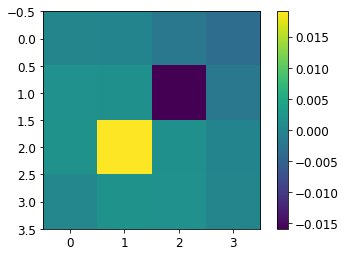

tf.Tensor(
[[ 0.         -0.00015625 -0.001875   -0.0034375 ]
 [ 0.00171875  0.0015625  -0.0159375  -0.001875  ]
 [ 0.001875    0.0190625   0.0015625  -0.00015625]
 [ 0.0003125   0.001875    0.00171875  0.        ]], shape=(4, 4), dtype=float32)
[[ 0.         -0.00015625 -0.001875   -0.0034375 ]
 [ 0.00171875  0.0015625  -0.0159375  -0.001875  ]
 [ 0.001875    0.0190625   0.0015625  -0.00015625]
 [ 0.0003125   0.001875    0.00171875  0.        ]]
0.0


(1, 4, 4, 1)

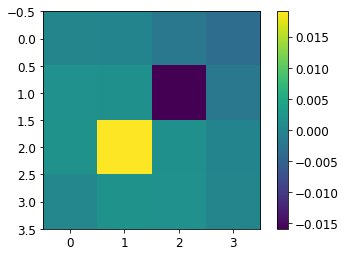

In [326]:
plt.imshow(w_4[0,:,:,0])
plt.colorbar()
plt.show()

w2_1 = np.load('/content/parallel_residuals/w2_0.npy')
w2_2 = np.load('/content/parallel_residuals/w2_1.npy')
w2_3 = np.load('/content/parallel_residuals/w2_2.npy')
w2_4 = np.load('/content/parallel_residuals/w2_3.npy')

parallel_w2_1 = np.concatenate([w2_1,w2_2],axis=2) # this time we only need to combine horizontally
parallel_w2_2 = np.concatenate([w2_3,w2_4],axis=2) # this time we only need to combine horizontally
parallel_w2 = np.concatenate([parallel_w2_1,parallel_w2_2],axis=1)
plt.imshow(parallel_w2[0,:,:,0])
plt.colorbar()

print(w_4[0,:,:,0])
print(parallel_w2[0,:,:,0])
print(np.abs(LA.norm(w_4[0,:,:,0]) - LA.norm(parallel_w2[0,:,:,0])) / (4*4))
parallel_w2.shape

In [327]:
# from pprint import pprint
# w4_1_p = np.load('/content/parallel_residuals/w4_prolong_0.npy')
# w4_2_p = np.load('/content/parallel_residuals/w4_prolong_1.npy')
# w4_3_p = np.load('/content/parallel_residuals/w4_prolong_2.npy')
# w4_4_p = np.load('/content/parallel_residuals/w4_prolong_3.npy')

# parallel_w4_1_p = np.concatenate([w4_1_p,w4_2_p],axis=2) # this time we only need to combine horizontally
# parallel_w4_2_p = np.concatenate([w4_3_p,w4_4_p],axis=2) # this time we only need to combine horizontally
# parallel_w4_p = np.concatenate([parallel_w4_1_p,parallel_w4_2_p],axis=1)
# plt.imshow(parallel_w4_p[0,:,:,0])
# plt.colorbar()
# # pprint(parallel_w4_p[0,:,:,0])

## residual 8x8

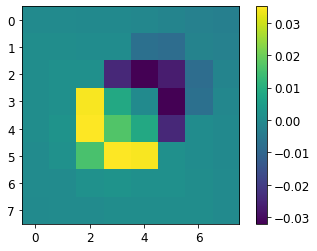

0.0


(1, 8, 8, 1)

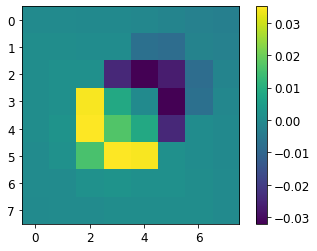

In [328]:
plt.imshow(w_8[0,:,:,0])
plt.colorbar()
plt.show()

w4_1 = np.load('/content/parallel_residuals/w4_0.npy')
w4_2 = np.load('/content/parallel_residuals/w4_1.npy')
w4_3 = np.load('/content/parallel_residuals/w4_2.npy')
w4_4 = np.load('/content/parallel_residuals/w4_3.npy')

parallel_w4_1 = np.concatenate([w4_1,w4_2],axis=2) # this time we only need to combine horizontally
parallel_w4_2 = np.concatenate([w4_3,w4_4],axis=2) # this time we only need to combine horizontally
parallel_w4 = np.concatenate([parallel_w4_1,parallel_w4_2],axis=1)
plt.imshow(parallel_w4[0,:,:,0])
plt.colorbar()
# print(w_8[0,:,:,0])
# print(parallel_w4[0,:,:,0])
print(np.abs(LA.norm(w_8[0,:,:,0]) - LA.norm(parallel_w4[0,:,:,0])) / (8*8))
parallel_w4.shape

## residual 16x16

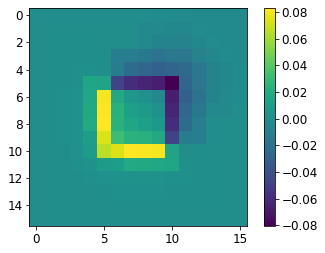

0.0


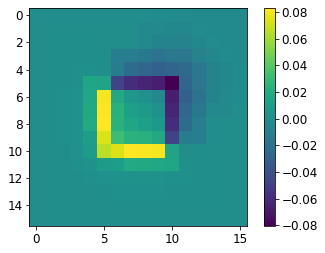

In [329]:
plt.imshow(w_16[0,:,:,0])
plt.colorbar()
plt.show()

w8_1 = np.load('/content/parallel_residuals/w8_0.npy')
w8_2 = np.load('/content/parallel_residuals/w8_1.npy')
w8_3 = np.load('/content/parallel_residuals/w8_2.npy')
w8_4 = np.load('/content/parallel_residuals/w8_3.npy')

parallel_w8_1 = np.concatenate([w8_1,w8_2],axis=2) # this time we only need to combine horizontally
parallel_w8_2 = np.concatenate([w8_3,w8_4],axis=2) # this time we only need to combine horizontally
parallel_w8 = np.concatenate([parallel_w8_1,parallel_w8_2],axis=1)
plt.imshow(parallel_w8[0,:,:,0])
plt.colorbar()
parallel_w8.shape
print(np.abs(LA.norm(w_16[0,:,:,0]) - LA.norm(parallel_w8[0,:,:,0])) / (16*16))

## residual 32x32

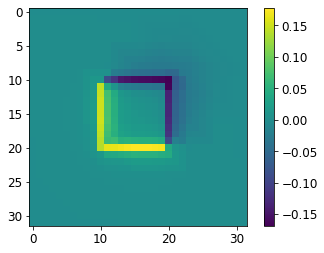

0.0


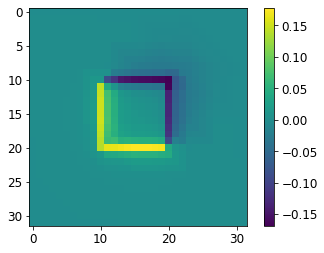

In [330]:
plt.imshow(w_32[0,:,:,0])
plt.colorbar()
plt.show()

w16_1 = np.load('/content/parallel_residuals/w16_0.npy')
w16_2 = np.load('/content/parallel_residuals/w16_1.npy')
w16_3 = np.load('/content/parallel_residuals/w16_2.npy')
w16_4 = np.load('/content/parallel_residuals/w16_3.npy')

parallel_w16_1 = np.concatenate([w16_1,w16_2],axis=2) # this time we only need to combine horizontally
parallel_w16_2 = np.concatenate([w16_3,w16_4],axis=2) # this time we only need to combine horizontally
parallel_w16 = np.concatenate([parallel_w16_1,parallel_w16_2],axis=1)
plt.imshow(parallel_w16[0,:,:,0])
plt.colorbar()
parallel_w16.shape
print(np.abs(LA.norm(w_32[0,:,:,0]) - LA.norm(parallel_w16[0,:,:,0])) / (32*32))

## residual 64x64

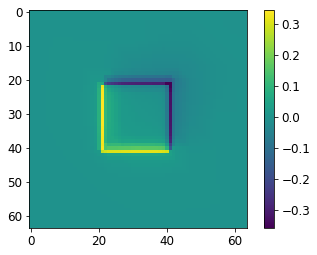

0.0


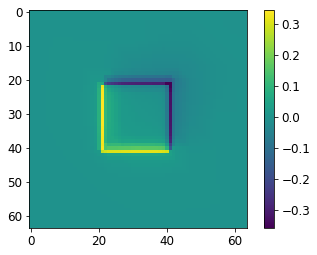

In [331]:
plt.imshow(w_64[0,:,:,0])
plt.colorbar()
plt.show()

w32_1 = np.load('/content/parallel_residuals/w32_0.npy')
w32_2 = np.load('/content/parallel_residuals/w32_1.npy')
w32_3 = np.load('/content/parallel_residuals/w32_2.npy')
w32_4 = np.load('/content/parallel_residuals/w32_3.npy')

parallel_w32_1 = np.concatenate([w32_1,w32_2],axis=2) # this time we only need to combine horizontally
parallel_w32_2 = np.concatenate([w32_3,w32_4],axis=2) # this time we only need to combine horizontally
parallel_w32 = np.concatenate([parallel_w32_1,parallel_w32_2],axis=1)
plt.imshow(parallel_w32[0,:,:,0])
plt.colorbar()
parallel_w32.shape
print(np.abs(LA.norm(w_64[0,:,:,0]) - LA.norm(parallel_w32[0,:,:,0])) / (64*64))

## residual 128x128

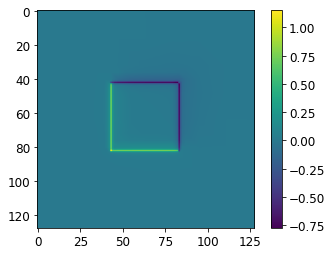

0.0


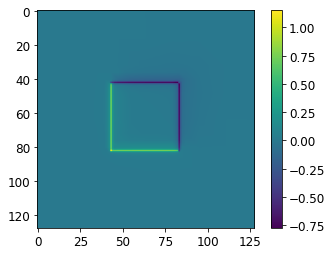

In [332]:
plt.imshow(w_128[0,:,:,0])
plt.colorbar()
plt.show()

w64_1 = np.load('/content/parallel_residuals/w64_0.npy')
w64_2 = np.load('/content/parallel_residuals/w64_1.npy')
w64_3 = np.load('/content/parallel_residuals/w64_2.npy')
w64_4 = np.load('/content/parallel_residuals/w64_3.npy')

parallel_w64_1 = np.concatenate([w64_1,w64_2],axis=2) # this time we only need to combine horizontally
parallel_w64_2 = np.concatenate([w64_3,w64_4],axis=2) # this time we only need to combine horizontally
parallel_w64 = np.concatenate([parallel_w64_1,parallel_w64_2],axis=1)
plt.imshow(parallel_w64[0,:,:,0])
plt.colorbar()
parallel_w64.shape
print(np.abs(LA.norm(w_128[0,:,:,0]) - LA.norm(parallel_w64[0,:,:,0])) / (128*128))